<a href="https://colab.research.google.com/github/HassaniAtefe/covid19-xray-images-detection-using-cnn/blob/main/Covid19_Xray_Images_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/images/classification#train_the_model

https://data.mendeley.com/datasets/2fxz4px6d8/4

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
! wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/2fxz4px6d8-4.zip

--2023-06-13 09:59:31--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/2fxz4px6d8-4.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.117.210, 52.218.116.2, 52.92.2.242, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.117.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181493505 (173M) [application/zip]
Saving to: ‘2fxz4px6d8-4.zip’

2fxz4px6d8-4.zip    100%[===================>] 173.08M  27.3MB/s    in 7.0s    

2023-06-13 09:59:39 (24.9 MB/s) - ‘2fxz4px6d8-4.zip’ saved [181493505/181493505]



In [3]:
! unzip 2fxz4px6d8-4.zip -d Covid19

Archive:  2fxz4px6d8-4.zip
  inflating: Covid19/Augmented COVID-19 X-ray Images Dataset/Dataset All Augmented/Dataset All Augmented.zip  
  inflating: Covid19/Augmented COVID-19 X-ray Images Dataset/Dataset COVID-19 Augmented/Dataset COVID-19 Augmented.zip  


In [4]:
! unzip /content/Covid19/Augmented\ COVID-19\ X-ray\ Images\ Dataset/Dataset\ COVID-19\ Augmented/Dataset\ COVID-19\ Augmented.zip -d COVID-19Augmented

Archive:  /content/Covid19/Augmented COVID-19 X-ray Images Dataset/Dataset COVID-19 Augmented/Dataset COVID-19 Augmented.zip
   creating: COVID-19Augmented/Dataset COVID-19 Augmented/
   creating: COVID-19Augmented/Dataset COVID-19 Augmented/COVID-19/
  inflating: COVID-19Augmented/Dataset COVID-19 Augmented/COVID-19/COVID-19 (1).jpeg  
  inflating: COVID-19Augmented/Dataset COVID-19 Augmented/COVID-19/COVID-19 (1).jpg  
  inflating: COVID-19Augmented/Dataset COVID-19 Augmented/COVID-19/COVID-19 (1).png  
  inflating: COVID-19Augmented/Dataset COVID-19 Augmented/COVID-19/COVID-19 (10).jpeg  
  inflating: COVID-19Augmented/Dataset COVID-19 Augmented/COVID-19/COVID-19 (10).jpg  
  inflating: COVID-19Augmented/Dataset COVID-19 Augmented/COVID-19/COVID-19 (100).jpg  
  inflating: COVID-19Augmented/Dataset COVID-19 Augmented/COVID-19/COVID-19 (101).jpg  
  inflating: COVID-19Augmented/Dataset COVID-19 Augmented/COVID-19/COVID-19 (102).jpg  
  inflating: COVID-19Augmented/Dataset COVID-19 Au

In [5]:
import pathlib
data_dir = "/content/COVID-19Augmented/Dataset COVID-19 Augmented"
data_dir = pathlib.Path(data_dir)

In [6]:
data_dir

PosixPath('/content/COVID-19Augmented/Dataset COVID-19 Augmented')

In [7]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1824


In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1824 files belonging to 2 classes.
Using 1460 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1824 files belonging to 2 classes.
Using 364 files for validation.


In [11]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
class_names = train_ds.class_names
print(class_names)

['COVID-19', 'Non-COVID-19']


In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9477193


In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
46/46 [==============================] - 53s 1s/step - loss: 0.4065 - accuracy: 0.8267 - val_loss: 0.0835 - val_accuracy: 0.9643
Epoch 2/10
46/46 [==============================] - 54s 1s/step - loss: 0.0828 - accuracy: 0.9712 - val_loss: 0.0711 - val_accuracy: 0.9698
Epoch 3/10
46/46 [==============================] - 50s 1s/step - loss: 0.0716 - accuracy: 0.9753 - val_loss: 0.1101 - val_accuracy: 0.9753
Epoch 4/10
46/46 [==============================] - 52s 1s/step - loss: 0.0315 - accuracy: 0.9904 - val_loss: 0.0427 - val_accuracy: 0.9863
Epoch 5/10
46/46 [==============================] - 52s 1s/step - loss: 0.0104 - accuracy: 0.9973 - val_loss: 0.0245 - val_accuracy: 0.9918
Epoch 6/10
46/46 [==============================] - 53s 1s/step - loss: 0.0108 - accuracy: 0.9952 - val_loss: 0.1033 - val_accuracy: 0.9725
Epoch 7/10
46/46 [==============================] - 52s 1s/step - loss: 0.0115 - accuracy: 0.9973 - val_loss: 0.0346 - val_accuracy: 0.9863
Epoch 8/10
46/46 [==

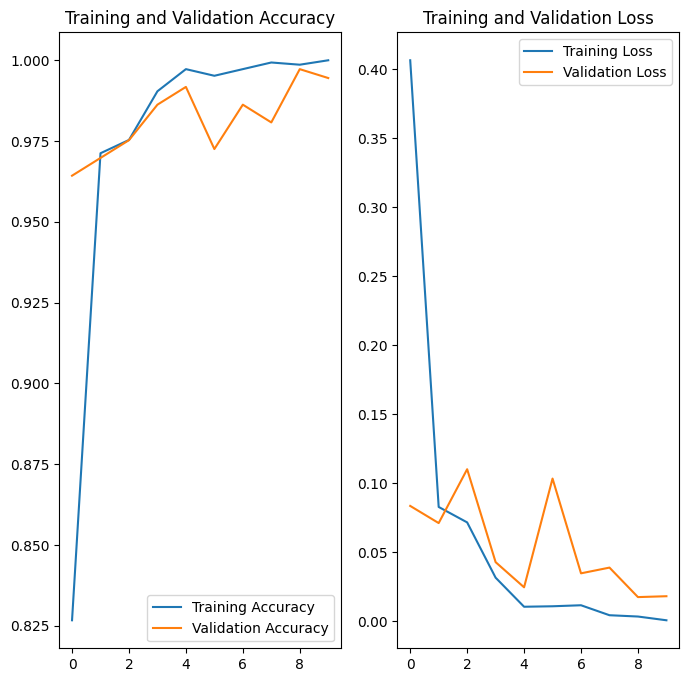

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()